In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

In [ ]:
def load_images_from_directory(base_dir):
    X = []
    y = []
    for class_label in range(10):
        class_dir = os.path.join(base_dir, str(class_label))
        # Get all image files in this class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]

        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            # Load image and convert to grayscale
            img = Image.open(img_path).convert('L')
            # Convert to numpy array and flatten
            img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
            X.append(img_array)
            y.append(class_label)

    return np.array(X), np.array(y)

#load from tsv files
def load_images_from_tsv(tsv_file, base_dir):
    X = []
    y = []

    # Read the tsv file
    df = pd.read_csv(tsv_file, sep='\t', header=None, names=['path', 'label'])

    for _, row in df.iterrows():
        img_path = os.path.join(base_dir, row['path'])
        class_label = row['label']

        # Load image and convert to grayscale
        img = Image.open(img_path).convert('L')
        # Convert to numpy array and flatten
        img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(class_label)

    return np.array(X), np.array(y)

Loading training data...
Training set size: 48000
Validation set size: 12000

Performing grid search for Linear SVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Linear SVM grid search completed in 124.76 seconds
Best parameters: {'C': 0.1}
Best cross-validation score: 0.9116

Linear SVM Cross-Validation Results:
   param_C  mean_test_score  std_test_score
0      0.1           0.9116        0.003444
1      1.0           0.9110        0.003444
2     10.0           0.9110        0.003444
3    100.0           0.9110        0.003444

Performing grid search for RBF SVM...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
RBF SVM grid search completed in 2879.87 seconds
Best parameters: {'C': 10, 'gamma': 'auto'}
Best cross-validation score: 0.9431

RBF SVM Cross-Validation Results:
    param_C param_gamma  mean_test_score  std_test_score
0       0.1       scale         0.869799        0.005563
1       0.1        auto         0.871300        0.004504
2       0.1  

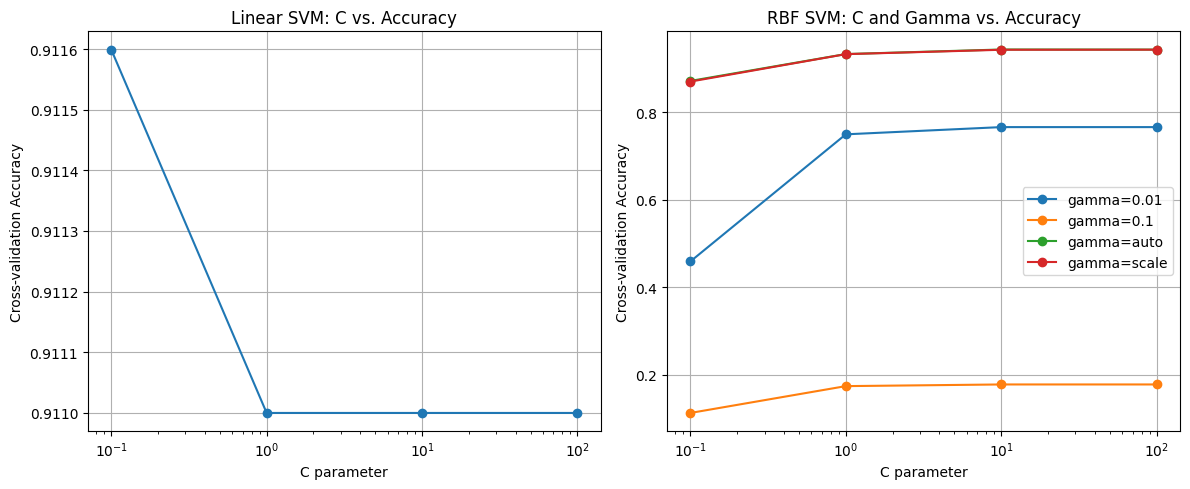

In [6]:
if __name__ == "__main__":
    # Data paths
    base_dir = "MNIST-full"
    train_dir = os.path.join(base_dir, "train")
    test_dir = os.path.join(base_dir, "test")

    # DATALOADINGD
    print("Loading training data...")
    X_train_full, y_train_full = load_images_from_directory(train_dir)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Cross-validation and hyperparameter tuning for Linear SVM
    print("\nPerforming grid search for Linear SVM...")
    param_grid_linear = {
        'C': [0.1, 1, 10, 100],
    }

    linear_svm = svm.SVC(kernel='linear',probability=True)
    grid_search_linear = GridSearchCV(
        linear_svm, param_grid_linear, cv=3, n_jobs=-1, verbose=2
    )

    # Train on a subset to speed up the grid search
    subset_size = 10000  # Use 10,000 examples for cross-validation
    X_subset = X_train_scaled[:subset_size]
    y_subset = y_train[:subset_size]

    start_time = time.time()
    grid_search_linear.fit(X_subset, y_subset)
    linear_time = time.time() - start_time

    print(f"Linear SVM grid search completed in {linear_time:.2f} seconds")
    print(f"Best parameters: {grid_search_linear.best_params_}")
    print(f"Best cross-validation score: {grid_search_linear.best_score_:.4f}")

    # Save cross-validation results for Linear SVM
    linear_cv_results = pd.DataFrame(grid_search_linear.cv_results_)
    linear_cv_results = linear_cv_results[['param_C', 'mean_test_score', 'std_test_score']]
    print("\nLinear SVM Cross-Validation Results:")
    print(linear_cv_results)

    # Cross-validation and hyperparameter tuning for RBF SVM
    print("\nPerforming grid search for RBF SVM...")
    param_grid_rbf = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    }

    rbf_svm = svm.SVC(kernel='rbf', probability=True)
    grid_search_rbf = GridSearchCV(
        rbf_svm, param_grid_rbf, cv=3, n_jobs=-1, verbose=2
    )

    start_time = time.time()
    grid_search_rbf.fit(X_subset, y_subset)
    rbf_time = time.time() - start_time

    print(f"RBF SVM grid search completed in {rbf_time:.2f} seconds")
    print(f"Best parameters: {grid_search_rbf.best_params_}")
    print(f"Best cross-validation score: {grid_search_rbf.best_score_:.4f}")

    # Save cross-validation results for RBF SVM
    rbf_cv_results = pd.DataFrame(grid_search_rbf.cv_results_)
    rbf_cv_results = rbf_cv_results[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]
    print("\nRBF SVM Cross-Validation Results:")
    print(rbf_cv_results)

    # Train the best models on the full training set
    print("\nTraining best Linear SVM model on full training set...")
    best_linear_svm = svm.SVC(
        kernel='linear',
        C=grid_search_linear.best_params_['C'],
        gamma='scale',
        probability=True
    )
    best_linear_svm.fit(X_train_scaled, y_train)

    print("Training best RBF SVM model on full training set...")
    best_rbf_svm = svm.SVC(
        kernel='rbf',
        C=grid_search_rbf.best_params_['C'],
        gamma=grid_search_rbf.best_params_['gamma'],
        probability=True
    )
    best_rbf_svm.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    print("\nEvaluating on validation set...")
    linear_val_pred = best_linear_svm.predict(X_val_scaled)
    linear_val_acc = accuracy_score(y_val, linear_val_pred)
    print(f"Linear SVM validation accuracy: {linear_val_acc:.4f}")

    rbf_val_pred = best_rbf_svm.predict(X_val_scaled)
    rbf_val_acc = accuracy_score(y_val, rbf_val_pred)
    print(f"RBF SVM validation accuracy: {rbf_val_acc:.4f}")

    # Load test data
    print("\nLoading test data...")
    # Choose one of the loading methods:
    X_test, y_test = load_images_from_directory(test_dir)
    # Or:
    # X_test, y_test = load_images_from_tsv(os.path.join(base_dir, 'gt-test.tsv'), base_dir)

    print(f"Test set size: {X_test.shape[0]}")

    # Standardize test features
    X_test_scaled = scaler.transform(X_test)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    if linear_val_acc > rbf_val_acc:
        print("Linear SVM performed better on validation, using it for test evaluation")
        best_model = best_linear_svm
        kernel_type = "Linear"
    else:
        print("RBF SVM performed better on validation, using it for test evaluation")
        best_model = best_rbf_svm
        kernel_type = "RBF"

    test_pred = best_model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"{kernel_type} SVM test accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))

    # Visualization of results
    plt.figure(figsize=(12, 5))

    # Plot Linear SVM results
    plt.subplot(1, 2, 1)
    linear_results = linear_cv_results.groupby('param_C')['mean_test_score'].mean().reset_index()
    plt.plot(linear_results['param_C'], linear_results['mean_test_score'], 'o-')
    plt.xscale('log')
    plt.xlabel('C parameter')
    plt.ylabel('Cross-validation Accuracy')
    plt.title('Linear SVM: C vs. Accuracy')
    plt.grid(True)

    # Plot RBF SVM results
    plt.subplot(1, 2, 2)
    rbf_results = rbf_cv_results.pivot_table(
        index='param_C',
        columns='param_gamma',
        values='mean_test_score'
    )

    # Convert string gamma values to numeric for plotting
    gamma_values = rbf_results.columns.tolist()
    gamma_labels = [str(g) for g in gamma_values]

    for i, gamma in enumerate(gamma_values):
        plt.plot(rbf_results.index, rbf_results[gamma], 'o-', label=f'gamma={gamma_labels[i]}')

    plt.xscale('log')
    plt.xlabel('C parameter')
    plt.ylabel('Cross-validation Accuracy')
    plt.title('RBF SVM: C and Gamma vs. Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('svm_parameter_tuning.png')
    plt.show()

In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluating the best model on the test set
print("\nEvaluating on test set...")

# Determine the best model based on validation accuracy
if linear_val_acc > rbf_val_acc:
    print("Linear SVM performed better on validation, using it for test evaluation")
    best_model = best_linear_svm
    kernel_type = "Linear"
    best_params = grid_search_linear.best_params_
else:
    print("RBF SVM performed better on validation, using it for test evaluation")
    best_model = best_rbf_svm
    kernel_type = "RBF"
    best_params = grid_search_rbf.best_params_

# Print the best model's parameters
print(f"\nBest model: {kernel_type} SVM")
print(f"Best parameters: C = {best_params['C']}", end="")
if kernel_type == "RBF":
    print(f", gamma = {best_params['gamma']}")
else:
    print()

# Evaluate the best model on the test set
test_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)

# Print the test accuracy and classification report
print(f"{kernel_type} SVM Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, test_pred))




Evaluating on test set...
RBF SVM performed better on validation, using it for test evaluation

Best model: RBF SVM
Best parameters: C = 10, gamma = auto
RBF SVM Test Accuracy: 0.9714

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.97      0.96       892
           6       0.99      0.98      0.98       958
           7       0.94      0.97      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

